# Setup

In [1]:
#@title #**Setup:** Imports and dependencies
#@markdown Install and import Python dependencies.
print('Installing dependencies...')
# !pip install inseq
!pip install jsonlines
print('Importing libraries...')
from transformers import GPT2Tokenizer
import argparse
import numpy as np
from collections import defaultdict
import torch
import pandas as pd
import inseq
import gc
import jsonlines
from IPython.display import clear_output
import numpy as np
clear_output()

print('Done!')

Done!


In [2]:
from transformers import GPT2Tokenizer

In [ ]:
#@title #**Setup:** load Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#@title #**Setup:** Set seed

import random
random.seed(42)

In [53]:
#@title #**Utils:** reciprocal_rank, average, tokenizer

def average(lst):
  return sum(lst)/len(lst)

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

def reciprocal_rank(predictions, targets):
    # Combine predictions and targets into pairs
    pairs = list(zip(predictions, targets))

    # Sort the pairs based on the prediction values (in descending order)
    sorted_pairs = sorted(pairs, key=lambda x: x[0], reverse=True)

    # Find the rank of the first correct prediction
    rank = next((i + 1 for i, (pred, target) in enumerate(sorted_pairs) if target), 0)

    # Calculate reciprocal rank
    reciprocal_rank = 1 / rank if rank > 0 else 0

    return reciprocal_rank

def get_target(sentence):
    b = sentence.split(' ')
    prefix_l = 0
    postix_l = 0
    target_l = 0
    check = False
    for i,word in enumerate(b):
        if i != 0:
            word = " "+word
            
        if check == True:
            postix_l += len(tokenizer(word)['input_ids'])
        if "n't" in word:
            target_l = len(tokenizer(word)['input_ids'])
            check = True
        if check == False:
            prefix_l += len(tokenizer(word)['input_ids'])
    return([False]*prefix_l+[True]*target_l+[False]*postix_l)

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False]

# Data

In [55]:
#@title #**Data:** load in NPI from BLIMP
# filename = "npi_present_1" #@param ["npi_present_1", 'npi_present_2', "only_npi_scope", "distractor_agreement_relational_noun", "determiner_noun_agreement_1"]
# with jsonlines.open( filename + ".jsonl", 'r') as f:
#     dataframe = pd.DataFrame(f)
sentences = []
values = []
with open("prefix+value.tsv", 'r', encoding='utf-8') as ifh:
    for line in ifh:
        sentence, value = line.strip().split('\t')
        sentences.append(sentence)
        values.append(value)
print(sentence,value)

We don't want to raise 3.671572208404541


In [14]:
#@title #**Data:** Show data
dataframe

,sentence_good,sentence_bad,one_prefix_prefix,one_prefix_word_good,one_prefix_word_bad,field,linguistics_term,UID,simple_LM_method,one_prefix_method,two_prefix_method,lexically_identical,pairID
0,Even Suzanne has really joked around.,Even Suzanne has ever joked around.,Even Suzanne has,really,ever,semantics,npi_licensing,npi_present_1,True,True,False,False,0
1,Even many teenagers clearly boycott those legi...,Even many teenagers ever boycott those legisla...,Even many teenagers,clearly,ever,semantics,npi_licensing,npi_present_1,True,True,False,False,1
2,Even every cashier had clearly found out who h...,Even every cashier had ever found out who hasn...,Even every cashier had,clearly,ever,semantics,npi_licensing,npi_present_1,True,True,False,False,2
3,Even Mark might often irritate the pedestrians.,Even Mark might ever irritate the pedestrians.,Even Mark might,often,ever,semantics,npi_licensing,npi_present_1,True,True,False,False,3
4,Even Tara had really baked.,Even Tara had ever baked.,Even Tara had,really,ever,semantics,npi_licensing,npi_present_1,True,True,False,False,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Even a lot of drivers often see Sonia.,Even a lot of drivers ever see Sonia.,Even a lot of drivers,often,ever,semantics,npi_licensing,npi_present_1,True,True,False,False,995
996,Even some banks had certainly motivated Roger ...,Even some banks had ever motivated Roger to sa...,Even some banks had,certainly,ever,semantics,npi_licensing,npi_present_1,True,True,False,False,996
997,Even Rebecca clearly cheered.,Even Rebecca ever cheered.,Even Rebecca,clearly,ever,semantics,npi_licensing,npi_present_1,True,True,False,False,997
998,Even some hospitals often continue to succeed.,Even some hospitals ever continue to succeed.,Even some hospitals,often,ever,semantics,npi_licensing,npi_present_1,True,True,False,False,998


# Run Experiments

In [58]:
#@title #**Loop through blimp NPI and give MRR**
import torch
explanations = ["input_x_gradient"] #"input_x_gradient", "integrated_gradients", "lime", "deeplift", "gradient_shap","discretized_integrated_gradients"
attributed_fn = "logit" #@param ["logit", "probability", "entropy", "crossentropy", "perplexity", "pcxmi", "kl_divergence", "in_context_pvi", "mc_dropout_prob_avg", "top_p_size"]
rev = 'True'
Results = {'Method': [], 'class':[], 'MRR': [], 'Dist': []}
Full_ranks = {"input_x_gradient":[], "integrated_gradients":[], "lime":[], "deeplift":[], "gradient_shap":[],"discretized_integrated_gradients":[]}

for explanation in explanations:

  gc.collect()
  model_inseq = inseq.load_model("gpt2", explanation)


  baseline_ranks = []
  contrastive_ranks = []
  dist = []
  i = 0
  for sentence in sentences:
    i += 1
    target = "any"
    foil = "some"

    baseline = model_inseq.attribute(
        sentence,
        sentence + " " + target,
        attributed_fn=attributed_fn,
    )

    contrast = model_inseq.attribute(
        sentence,
        sentence + " " + foil,
        attributed_fn=attributed_fn,
    )

    clear_output()
    print(f'target = {target}, foil = {foil}, sentence = {sentence} calculating {i}')
#     sent_len = len(tokenizer(sentence)['input_ids'])


    base_tensor = baseline[0].target_attributions
    contrastive_tensor = contrast[0].target_attributions


    baseline_att = base_tensor.sum(axis = 2)
    contrast_att = contrastive_tensor.sum(axis = 2)
    baseline_att = torch.flatten(baseline_att[~torch.any(baseline_att.isnan(),dim=1)]).numpy()
    contrast_att = torch.flatten(contrast_att[~torch.any(contrast_att.isnan(),dim=1)]).numpy()


#     if filename == 'determiner_noun_agreement_1':
#       targets = [False] * (sent_len - 1)+[True]
#     else:
#       targets = [True] + [False] * (sent_len - 1)

#     baseline_att = baseline_att[:len(targets)]
#     contrast_att = contrast_att[:len(targets)]
    targets = get_target(sentence)
    
    if rev == 'True':
      contrastive_attributions = contrast_att- baseline_att
    if rev == 'False':
      contrastive_attributions = baseline_att-contrast_att

    rank_baseline = reciprocal_rank(baseline_att, targets)
    rank_contrastive = reciprocal_rank(contrastive_attributions, targets)

    assert len(targets) == len(baseline_att), f'Target/Baseline mismatch \n targets = {targets},\n baseline_att = {baseline_att}'
    assert len(targets) == len(contrastive_attributions), f'Target/Contrast mismatch {targets}, {contrast_att}'
    assert len(contrastive_attributions) == len(baseline_att), f'Baseline/Contrast mismatch {baseline_att}, {contrast_att}'

    baseline_ranks.append(rank_baseline)
    contrastive_ranks.append(rank_contrastive)
    dist.append(len(targets))


  AVG_dist = average(dist)
  MRR_baseline = average(baseline_ranks)
  MRR_contrastive = average(contrastive_ranks)

  Results['Method'].append(explanation)
  Results['Method'].append(explanation)

  Results['class'].append('baseline')
  Results['class'].append('contrastive')

  Results['MRR'].append(MRR_baseline)
  Results['MRR'].append(MRR_contrastive)

  Results['Dist'].append(AVG_dist)
  Results['Dist'].append(AVG_dist)

  print(Results)
dataframe_results = pd.DataFrame(data=Results)

target = any, foil = some, sentence = We don't want to raise calculating 3844
{'Method': ['input_x_gradient', 'input_x_gradient'], 'class': ['baseline', 'contrastive'], 'MRR': [0.45954726223666537, 0.5669575182796663], 'Dist': [6.986992715920915, 6.986992715920915]}


In [88]:
values = [float(x) for x in values]
sorted_data = sorted(zip(values, baseline_ranks, contrastive_ranks), key=lambda x: x[0])
x_sorted, y1_sorted, y2_sorted = zip(*sorted_data)

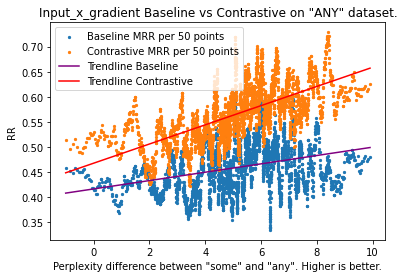

In [96]:
# Zip and sort based on x_values
import matplotlib.pyplot as plt


# Plotting with smaller dots
window_size = 50
y1_averages = np.convolve(y1_sorted, np.ones(window_size)/window_size, mode='valid')
y2_averages = np.convolve(y2_sorted, np.ones(window_size)/window_size, mode='valid')
x_averages = np.convolve(x_sorted, np.ones(window_size)/window_size, mode='valid')

# Fit polynomial trendlines
degree = 1  # You can adjust the degree of the polynomial
z1 = np.polyfit(x_averages, y1_averages, degree)
z2 = np.polyfit(x_averages, y2_averages, degree)

# Create polynomial functions
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)


# Plotting
plt.scatter(x_averages[:len(y1_averages)], y1_averages, label='Baseline MRR per 50 points', s=5)
plt.scatter(x_averages[:len(y2_averages)], y2_averages, label='Contrastive MRR per 50 points', s=5)

# Plot trendlines
plt.plot(x_averages, p1(x_averages), label='Trendline Baseline', color='purple')
plt.plot(x_averages, p2(x_averages), label='Trendline Contrastive', color='red')

# Adding labels and legend
plt.xlabel('Perplexity difference between "some" and "any". Higher is better.')
plt.ylabel('RR')
plt.legend()
plt.title('Input_x_gradient Baseline vs Contrastive on "ANY" dataset.')
# Set a higher resolution (dpi) for the plot
plt.savefig('scatter_plot_averages.png', dpi=400)  # Adjust the filename and dpi as needed
plt.show()

In [15]:
#@title #**Inseq:** True LIME and Descratised Integrated Gradients
import torch
explanations = ["lime"] #, "discretized_integrated_gradients"
Results = {'Method': [], 'class':[], 'MRR': []}

torch.cuda.empty_cache()
gc.collect()


for explanation in explanations:

  gc.collect()
  model_inseq = inseq.load_model("gpt2", explanation)

  baseline_ranks = []
  contrastive_ranks = []
  dist = []
  i = 0
  for index, row in dataframe.iterrows():
    i += 1
    sentence = row["one_prefix_prefix"]
    target = row["one_prefix_word_bad"]
    foil = row["one_prefix_word_good"]

    out = model_inseq.attribute(
        sentence,
        sentence + " " + target,
        attributed_fn= "contrast_logits_diff",
        contrast_targets= sentence + " " + foil,
        # We also visualize the corresponding step score
        step_scores=["contrast_logits_diff"]
    )

    clear_output()
    print(f'target = {target}, foil = {foil}, sentence = {sentence} calculating {i}/1000')
    sent_len = len(tokenizer(sentence)['input_ids'])


    base_tensor = out[0].target_attributions
    baseline_att = base_tensor.sum(axis = 2)
    baseline_att = torch.flatten(baseline_att[~torch.any(baseline_att.isnan(),dim=1)]).numpy()

    if filename == 'determiner_noun_agreement_1':
      targets = [False] * (sent_len - 1)+[True]
    else:
      targets = [True] + [False] * (sent_len - 1)

    rank_baseline = reciprocal_rank(baseline_att, targets)

    assert len(targets) == len(baseline_att), f'Target/Baseline mismatch \n targets = {targets},\n baseline_att = {baseline_att}'

    baseline_ranks.append(rank_baseline)
    dist.append(sent_len)

  AVG_dist = average(dist)
  MRR_baseline = average(baseline_ranks)

  Results['Method'].append(explanation)

  Results['class'].append('baseline')

  Results['MRR'].append(MRR_baseline)

  Results['Dist'].append(AVG_dist)



  print(Results)
dataframe_results = pd.DataFrame(data=Results)

target = ever, foil = clearly, sentence = Even the cashiers had calculating 1000/1000
{'Method': ['lime'], 'class': ['baseline'], 'MRR': [0.5014499999999973]}


# Results

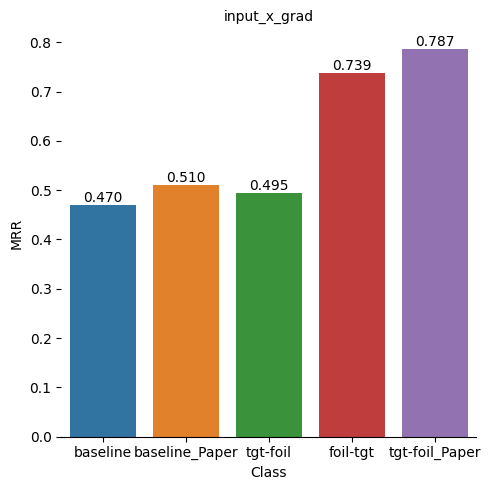

In [ ]:
#@title #**Results:** npi_present_1 reversal results.
results_npi_1 = {'Method': ['input_x_grad','input_x_grad', 'input_x_grad','input_x_grad', 'input_x_grad'],'class': ['baseline','baseline_Paper','tgt-foil','foil-tgt','tgt-foil_Paper'], 'MRR':[0.4699,0.510,0.4948,0.738683333,0.787]}
df_res = pd.DataFrame(data=results_npi_1)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')
# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')

# Show the plot
plt.show()

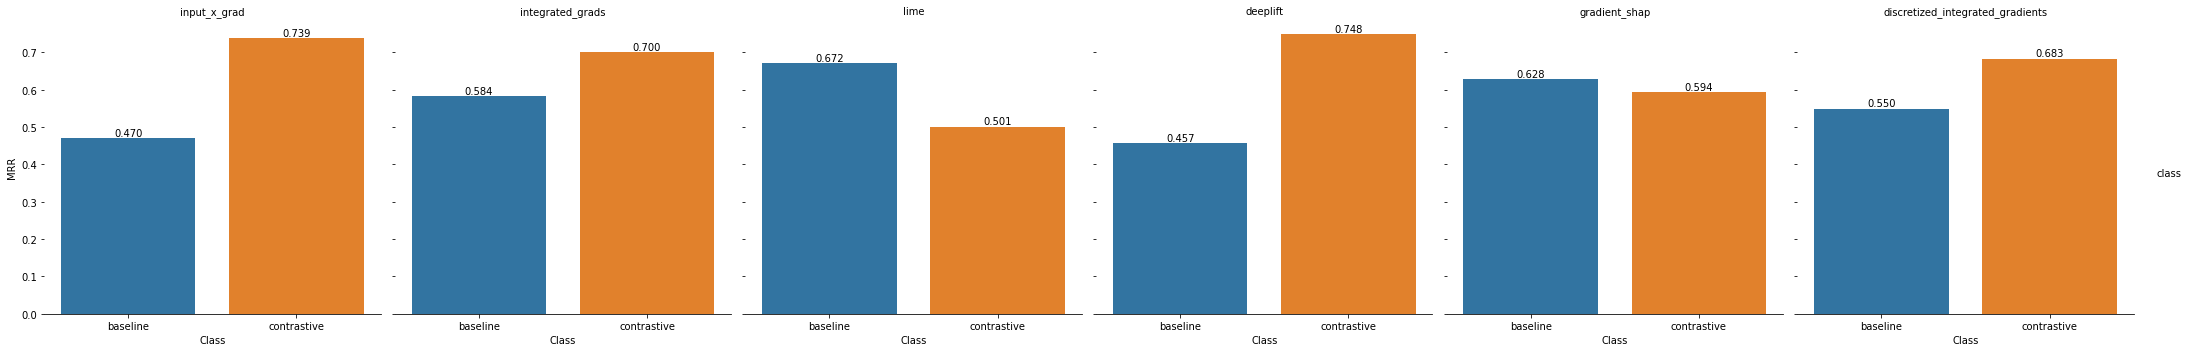

In [16]:
#@title #**Results:** npi_present_1 results.

results_npi_1 = {'Method': ['input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients','input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients'],'class': ['baseline','baseline','baseline','baseline','baseline','baseline', 'contrastive','contrastive','contrastive','contrastive','contrastive','contrastive'], 'MRR':[0.4699,0.5841333333, 0.6716833333,0.45684999999 ,0.6275928, 0.54976666666 ,0.738683333,0.69993571, 0.5014499999999973,0.748433333,0.5938833,  0.6834761904]}
df_res = pd.DataFrame(data=results_npi_1)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')

# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')

# Show the plot
plt.show()

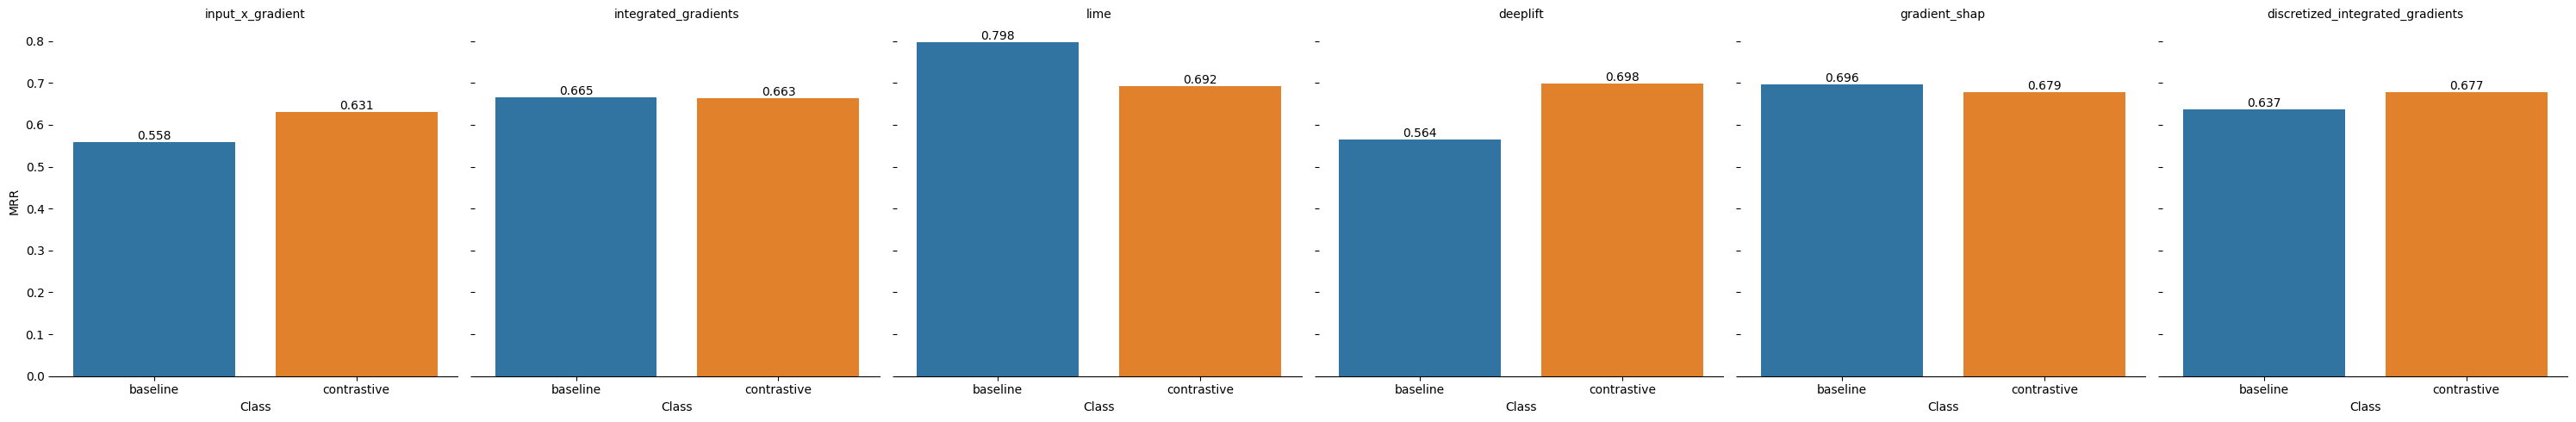

In [ ]:
#@title #**Results:** npi_present_2 results.

results_npi_2 = {'Method': ['input_x_gradient', 'input_x_gradient', 'integrated_gradients', 'integrated_gradients', 'lime', 'lime', 'deeplift', 'deeplift', 'gradient_shap', 'gradient_shap', 'discretized_integrated_gradients', 'discretized_integrated_gradients'], 'class': ['baseline', 'contrastive', 'baseline', 'contrastive', 'baseline', 'contrastive', 'baseline', 'contrastive', 'baseline', 'contrastive', 'baseline', 'contrastive'], 'MRR': [0.5579499999999994, 0.6310166666666669, 0.6647666666666667, 0.6632000000000005, 0.7978833333333338, 0.6919000000000005, 0.5639999999999991, 0.6976000000000007, 0.6956000000000004, 0.678716666666667,0.6370833333333334, 0.6774000000000001]}
df_res = pd.DataFrame(data=results_npi_2)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')

# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')
# Show the plot
plt.show()

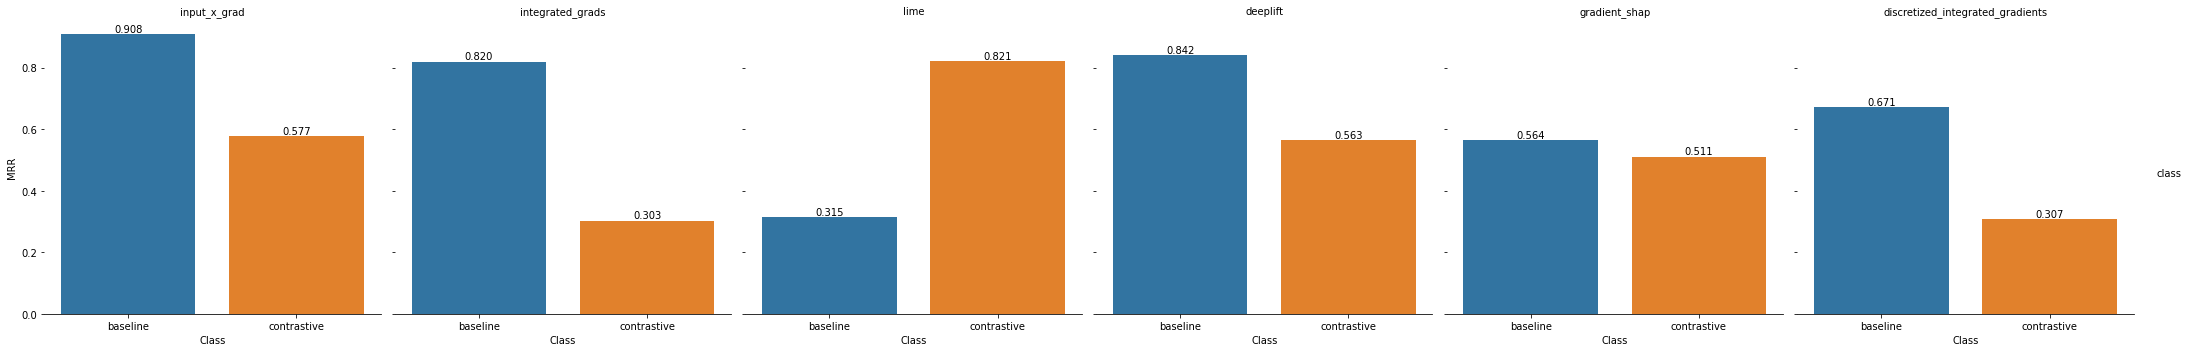

In [12]:
#@title #**Results:** determiner_noun_agreement_1 results.
import seaborn as sns
import matplotlib.pyplot as plt
results_determiner_noun = {'Method': ['input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients', 'discretized_integrated_gradients'],'class': ['baseline','baseline','baseline','baseline','baseline', 'contrastive','contrastive','contrastive','contrastive','contrastive', 'baseline', 'contrastive'], 'MRR':[0.9082428571428581,0.8196607142857156,0.31504126984126846,0.8419928571428584,0.5638011904761897,0.5770000000000003,0.30320277777777643,0.8205642857142863,0.5633964285714284,0.5110353174603166,0.6711214285714291,0.3070515873015864]}
df_res = pd.DataFrame(data=results_determiner_noun)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')

# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')
# Show the plot
plt.show()

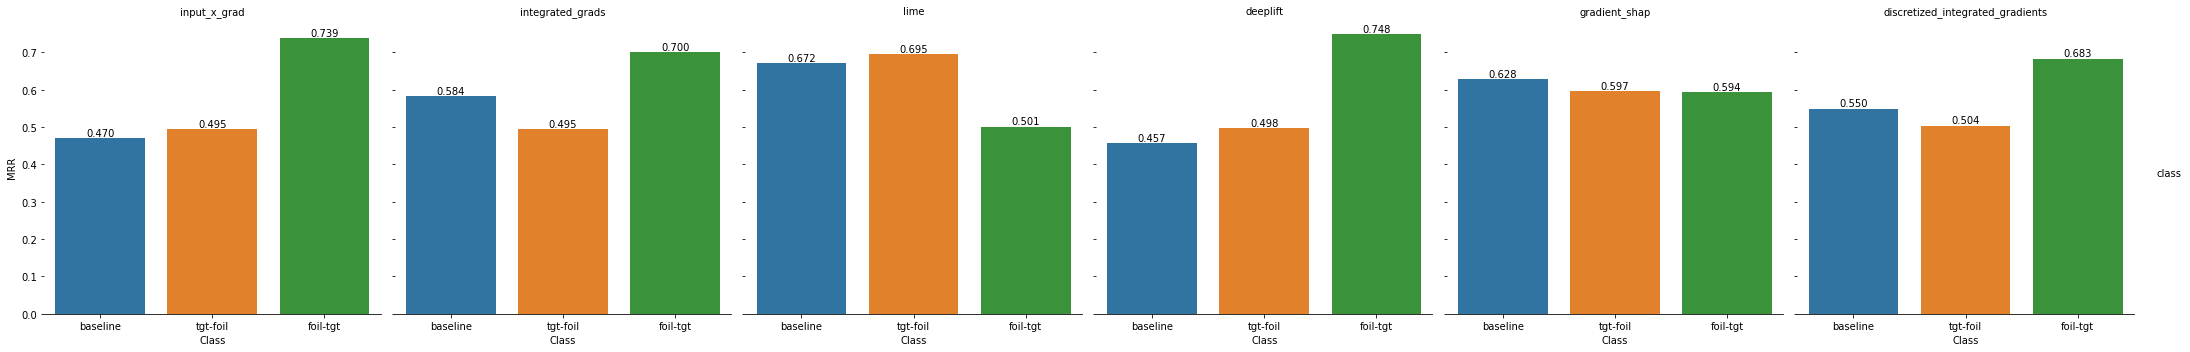

In [18]:
#@title #**Results:** determiner_noun_agreement_1 results.
import seaborn as sns
import matplotlib.pyplot as plt
results_npi_1 = {'Method': ['input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients','input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients','input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients'],'class': ['baseline','baseline','baseline','baseline','baseline','baseline','tgt-foil','tgt-foil','tgt-foil','tgt-foil','tgt-foil','tgt-foil', 'foil-tgt','foil-tgt','foil-tgt','foil-tgt','foil-tgt','foil-tgt'], 'MRR':[0.4699,0.5841333333, 0.6716833333,0.45684999999 ,0.6275928, 0.54976666666 ,0.4948, 0.49498333,0.6947166666666674,0.498061904, 0.597342857,0.50434999,0.738683333,0.69993571, 0.5014499999999973,0.748433333,0.5938833,  0.6834761904]}
df_res = pd.DataFrame(data=results_npi_1)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')

# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')
# Show the plot
plt.show()

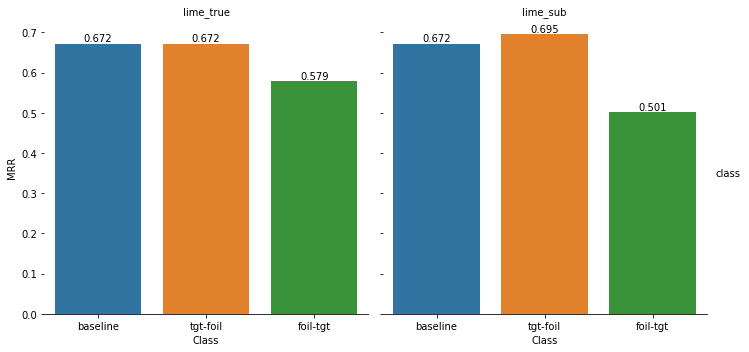

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
results_npi_1 = {'Method': ['lime_true', 'lime_sub', 'lime_true','lime_sub', 'lime_true','lime_sub'],'class': ['baseline','baseline','tgt-foil','tgt-foil', 'foil-tgt','foil-tgt'], 'MRR':[0.672,0.672,0.672,0.695,0.579,0.501]}
df_res = pd.DataFrame(data=results_npi_1)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')

# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')
# Show the plot
plt.show()

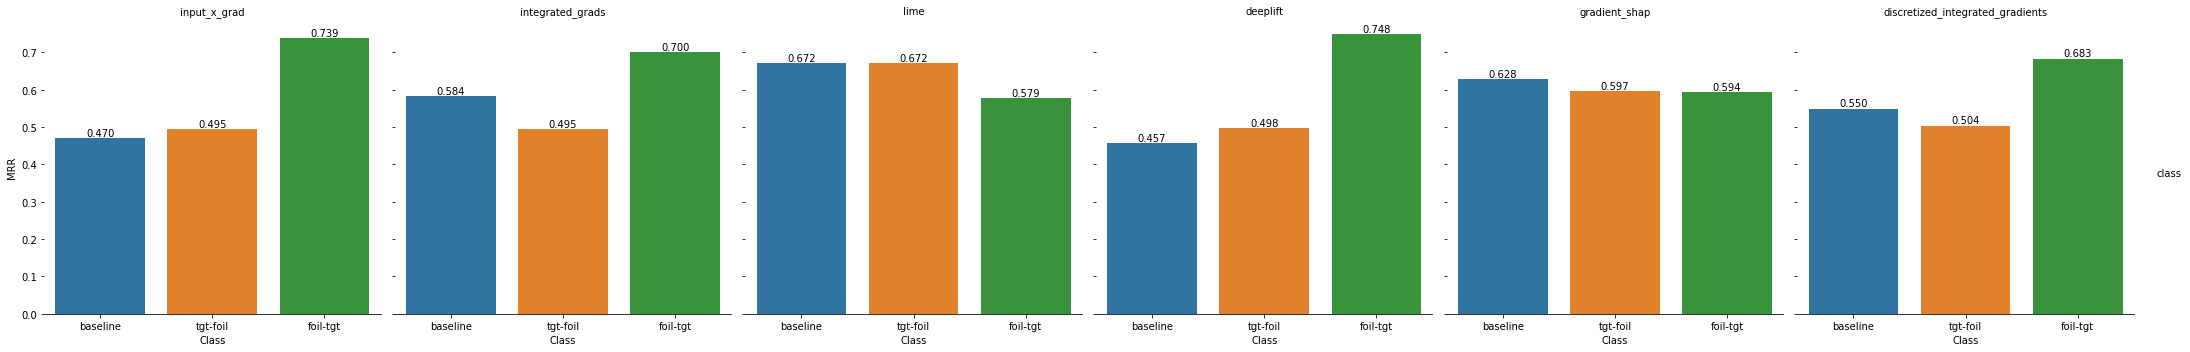

In [19]:
#@title #**Results:** determiner_noun_agreement_1 results.
import seaborn as sns
import matplotlib.pyplot as plt
results_npi_1 = {'Method': ['input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients','input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients','input_x_grad', 'integrated_grads', 'lime', 'deeplift', 'gradient_shap', 'discretized_integrated_gradients'],'class': ['baseline','baseline','baseline','baseline','baseline','baseline','tgt-foil','tgt-foil','tgt-foil','tgt-foil','tgt-foil','tgt-foil', 'foil-tgt','foil-tgt','foil-tgt','foil-tgt','foil-tgt','foil-tgt'], 'MRR':[0.4699,0.5841333333, 0.6716833333,0.45684999999 ,0.6275928, 0.54976666666 ,0.4948, 0.49498333,0.67236904,0.498061904, 0.597342857,0.50434999,0.738683333,0.69993571, 0.5787190476,0.748433333,0.5938833,  0.6834761904]}
df_res = pd.DataFrame(data=results_npi_1)
# Assuming 'class' is the column containing class information
g = sns.catplot(kind='bar', data=df_res, x='class', y='MRR', col='Method', hue='class')

# Customize the plot as needed
g.set_axis_labels('Class', 'MRR')
g.set_titles(col_template='{col_name}')
g.despine(left=True)

# Add values on top of the bars
for ax in g.axes.flat:
    for p in ax.patches:
        ax.text(p.get_x() + p.get_width() / 2., p.get_height(), f'{p.get_height():.3f}', ha='center', va='bottom')
# Show the plot
plt.show()

# Old Code from here down

In [ ]:
#@title #**Loop through blimp NPI and give MRR**
import torch
explanation = "deeplift" #@param ["input_x_gradient", "integrated_gradients", "occlusion", "lime", "deeplift", "gradient_shap", "discretized_integrated_gradients"]
aggregator = "sum" #@param ["sum", "mean", "vnorm", "max", "min", "prod", "absmax", "default"]
attributed_fn = "logit" #@param ["logit", "probability", "entropy", "crossentropy", "perplexity", "pcxmi", "kl_divergence", "in_context_pvi", "mc_dropout_prob_avg", "top_p_size"]
rev = "False" #@param ['True', 'False']
gc.collect()
model_inseq = inseq.load_model("gpt2", explanation)

baseline_ranks = []
contrastive_ranks = []
dist = []

for index, row in dataframe.iterrows():
  sentence = row["one_prefix_prefix"]
  target = row["one_prefix_word_good"]
  foil = row["one_prefix_word_bad"]


  # encoded_target = tokenizer(' '+ target)['input_ids'][0]
  # target = tokenizer.decode(encoded_target)

  # encoded_foil = tokenizer(' '+ foil)['input_ids'][0]
  # foil = tokenizer.decode(encoded_foil)


  baseline = model_inseq.attribute(
      sentence,
      sentence + " " + target,
      attributed_fn=attributed_fn,
  )


  contrast = model_inseq.attribute(
      sentence,
      sentence + " " + foil,
      attributed_fn=attributed_fn,
  )

  clear_output()
  print(f'target = {target}, foil = {foil}, sentence = {sentence}')
  sent_len = len(tokenizer(sentence)['input_ids'])


  base_tensor = baseline[0].target_attributions
  contrastive_tensor = contrast[0].target_attributions

  print(base_tensor.size())
  print(contrastive_tensor.size())


  # contrastive_feature = base_tensor-contrastive_tensor
  # contrastive = copy.deepcopy(baseline)
  # contrastive[0].target_attributions = contrastive_feature
  baseline_att = base_tensor.sum(axis = 2)
  contrast_att = contrastive_tensor.sum(axis = 2)
  baseline_att = torch.flatten(baseline_att[~torch.any(baseline_att.isnan(),dim=1)]).numpy()
  contrast_att = torch.flatten(contrast_att[~torch.any(contrast_att.isnan(),dim=1)]).numpy()


  if filename == 'determiner_noun_agreement_1':
    targets = [False] * (sent_len - 1)+[True]
  else:
    targets = [True] + [False] * (sent_len - 1)
  baseline_att = baseline_att[:len(targets)]
  contrast_att = contrast_att[:len(targets)]

  if rev == 'True':
    contrastive_attributions = contrast_att- baseline_att
  if rev == 'False':
    contrastive_attributions = baseline_att-contrast_att

  rank_baseline = reciprocal_rank(baseline_att, targets)
  rank_contrastive = reciprocal_rank(contrastive_attributions, targets)

  assert len(targets) == len(baseline_att), f'Target/Baseline mismatch \n targets = {targets},\n baseline_att = {baseline_att}'
  assert len(targets) == len(contrastive_attributions), f'Target/Contrast mismatch {targets}, {contrast_att}'
  assert len(contrastive_attributions) == len(baseline_att), f'Baseline/Contrast mismatch {baseline_att}, {contrast_att}'

  baseline_ranks.append(rank_baseline)
  contrastive_ranks.append(rank_contrastive)
  dist.append(sent_len)


AVG_dist = average(dist)
MRR_baseline = average(baseline_ranks)
MRR_contrastive = average(contrastive_ranks)

print(f'Average Distance is   {AVG_dist}')
print(f'Baseline MRR is       {MRR_baseline}')
print(f'Contrastive MRR is    {MRR_contrastive}')

image.png

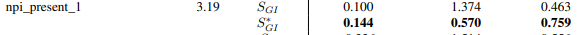

npi_present_1:

Average Distance is   3.15

Baseline MRR is       0.470

Contrastive MRR is    0.495


---



npi_present_2:

Average Distance is   2.489

Baseline MRR is       0.558

Contrastive MRR is    0.769


---

............image.png

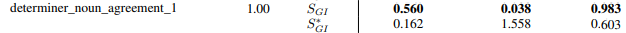

determiner_noun_agreement_1

Average Distance is   1 (always)

Baseline MRR is       0.908

Contrastive MRR is    0.394


---



npi_present_1: REVERSED

Average Distance is   3.15

Baseline MRR is       0.470

Contrastive MRR is    0.739


---

determiner_noun_agreement_1: REVERSED

Average Distance is   1 (always)

Baseline MRR is       0.908

Contrastive MRR is    0.577


In [ ]:
#@title #**Plots** ?

# Data for MRR-baseline
labels_baseline = ['npi-1', 'npi-1*','npi-1-rev', 'det', 'det*',  'det-rev']
MRR_baseline = [0.470, 0.463, 0.470,0.908, 0.983,  0.908]

# Data for MRR-contrastive
labels_contrastive = ['npi-1', 'npi-1*','npi-1-rev', 'det', 'det*',  'det-rev']
MRR_contrastive = [0.495, 0.759, 0.739, 0.394, 0.603, 0.577]

# Color palette
colors = sns.color_palette('Dark2')

# Plotting MRR-baseline and MRR-contrastive horizontally
fig, (ax_baseline, ax_contrastive) = plt.subplots(1, 2, figsize=(16, 6))

# Bar width
bar_width = 0.4
bar_positions = np.arange(len(labels_baseline))

# Bar plots for MRR-baseline
ax_baseline.bar(bar_positions, MRR_baseline, color=colors[0], width=bar_width, edgecolor='grey', label='MRR-baseline')

# Adding labels and legend for MRR-baseline
ax_baseline.set_xlabel('Labels', fontweight='bold', fontsize=15)
ax_baseline.set_xticks(bar_positions)
ax_baseline.set_xticklabels(labels_baseline)
ax_baseline.legend()

# Bar plots for MRR-contrastive
ax_contrastive.bar(bar_positions, MRR_contrastive, color=colors[1], width=bar_width, edgecolor='grey', label='MRR-contrastive')

# Adding labels and legend for MRR-contrastive
ax_contrastive.set_xlabel('Labels', fontweight='bold', fontsize=15)
ax_contrastive.set_xticks(bar_positions)
ax_contrastive.set_xticklabels(labels_contrastive)
ax_contrastive.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plots horizontally
plt.show()


In [ ]:
#@title #**Inseq:** explanations with paper hyperparams
sentence = "Can you stop the dog from" #@param {type:"string"}
target = "barking" #@param {type:"string"}
foil = "walking" #@param {type:"string"}
explanation = "input_x_gradient" #@param ["input_x_gradient", "integrated_gradients", "occlusion", "lime", "deeplift", "gradient_shap", "discretized_integrated_gradients"]
aggregator = "sum" #@param ["sum", "mean", "vnorm", "max", "min", "prod", "absmax", "default"]
attributed_fn = "logit" #@param ["logit", "probability", "entropy", "crossentropy", "perplexity", "pcxmi", "kl_divergence", "in_context_pvi", "mc_dropout_prob_avg", "top_p_size"]
contrast_attributed_fn = "contrast_logits_diff" #@param ["contrast_logits", "contrast_prob", "contrast_logits_diff", "contrast_prob_diff"]


torch.cuda.empty_cache()
gc.collect()
model_inseq = inseq.load_model("gpt2", explanation)


baseline = model_inseq.attribute(
    sentence,
    sentence + " " + target,
    internal_batch_size=50,
    attributed_fn=attributed_fn,
    n_steps=500
)


contrast = model_inseq.attribute(
    sentence,
    sentence + " " + foil,
    internal_batch_size=50,
    attributed_fn=attributed_fn,
    n_steps=500
)


contrastive_feature = baseline[0].target_attributions - contrast[0].target_attributions
contrastive = copy.deepcopy(baseline)
contrastive[0].target_attributions = contrastive_feature


if explanation in ["input_x_gradient","occlusion", "lime", "discretized_integrated_gradients"]:
  out = model_inseq.attribute(
      sentence,
      sentence + " " + target,
      attributed_fn= contrast_attributed_fn,
      contrast_targets= sentence + " " + foil,
      # We also visualize the corresponding step score
      step_scores=[contrast_attributed_fn]
  )


clear_output()


print("Baseline saliency with forced target")
baseline.show(aggregator = aggregator)
print("Baseline saliency with forced foil")
contrast.show(aggregator = aggregator)
print("Contrastive saliency by subtracting feature matrices")
contrastive.show(aggregator = aggregator)
if explanation in ["input_x_gradient","occlusion", "lime", "discretized_integrated_gradients"]:
  print("Contrastive saliency by inseq library")
  out.show(aggregator = aggregator)

In [ ]:
#@title #**Loop through blimp NPI and give MRR** Use for disc_int_grads
#@markdown I hate colab so much pls kill me.
import torch
explanations = ["input_x_gradient", "integrated_gradients", "lime", "deeplift", "gradient_shap"] #"discretized_integrated_gradients"
attributed_fn = "logit" #@param ["logit", "probability", "entropy", "crossentropy", "perplexity", "pcxmi", "kl_divergence", "in_context_pvi", "mc_dropout_prob_avg", "top_p_size"]
revs = ['True', 'False']
Results = []


for explanation in explanations:

  gc.collect()
  model_inseq = inseq.load_model("gpt2", explanation)

  for rev in revs:

    baseline_ranks = []
    contrastive_ranks = []
    dist = []

    for index, row in dataframe.iterrows():
      sentence = row["one_prefix_prefix"]
      target = row["one_prefix_word_good"]
      foil = row["one_prefix_word_bad"]

      baseline = model_inseq.attribute(
          sentence,
          sentence + " " + target,
          attributed_fn=attributed_fn,
      )

      contrast = model_inseq.attribute(
          sentence,
          sentence + " " + foil,
          attributed_fn=attributed_fn,
      )

      clear_output()
      print(f'target = {target}, foil = {foil}, sentence = {sentence}')
      sent_len = len(tokenizer(sentence)['input_ids'])


      base_tensor = baseline[0].target_attributions
      contrastive_tensor = contrast[0].target_attributions

      print(base_tensor.size())
      print(contrastive_tensor.size())


      baseline_att = base_tensor.sum(axis = 2)
      contrast_att = contrastive_tensor.sum(axis = 2)
      baseline_att = torch.flatten(baseline_att[~torch.any(baseline_att.isnan(),dim=1)]).numpy()
      contrast_att = torch.flatten(contrast_att[~torch.any(contrast_att.isnan(),dim=1)]).numpy()


      if filename == 'determiner_noun_agreement_1':
        targets = [False] * (sent_len - 1)+[True]
      else:
        targets = [True] + [False] * (sent_len - 1)

      baseline_att = baseline_att[:len(targets)]
      contrast_att = contrast_att[:len(targets)]

      if rev == 'True':
        contrastive_attributions = contrast_att- baseline_att
      if rev == 'False':
        contrastive_attributions = baseline_att-contrast_att

      rank_baseline = reciprocal_rank(baseline_att, targets)
      rank_contrastive = reciprocal_rank(contrastive_attributions, targets)

      assert len(targets) == len(baseline_att), f'Target/Baseline mismatch \n targets = {targets},\n baseline_att = {baseline_att}'
      assert len(targets) == len(contrastive_attributions), f'Target/Contrast mismatch {targets}, {contrast_att}'
      assert len(contrastive_attributions) == len(baseline_att), f'Baseline/Contrast mismatch {baseline_att}, {contrast_att}'

      baseline_ranks.append(rank_baseline)
      contrastive_ranks.append(rank_contrastive)
      dist.append(sent_len)


    AVG_dist = average(dist)
    MRR_baseline = average(baseline_ranks)
    MRR_contrastive = average(contrastive_ranks)

    Results.append((f'Method: {explanation}', [AVG_dist,MRR_baseline,MRR_contrastive]))
    print(Results)

hallo ik ben jan